# INCEpTION - Using pretokenized and preannotated text

This tutorial describes how to import documents into INCEpTION that are already split into sentences, pretokenized and might already contain annotations. We will use the [UIMA XMI format](https://uima.apache.org/d/uimaj-current/references.html#ugr.ref.xmi) and the Python library [cassis](https://github.com/dkpro/dkpro-cassis) for this. The underlying data structure for an annotated document in INCEpTION is called a CAS. A CAS contains the document text, as well as the annotations. XMI is a serialization format of a CAS that encodes it as XML.

**The type system**

Each INCEpTION project has a type system that describes what kind of annotations with which fields there are. This corresponds to the layers defined in INCEpTION. For instance, each default project has a *Named Entity* layer with a string feature called *value*. The type name can be seen in the INCEpTION layer configuration. In this case, it is *de.tudarmstadt.ukp.dkpro.core.api.ner.type.NamedEntity*. 







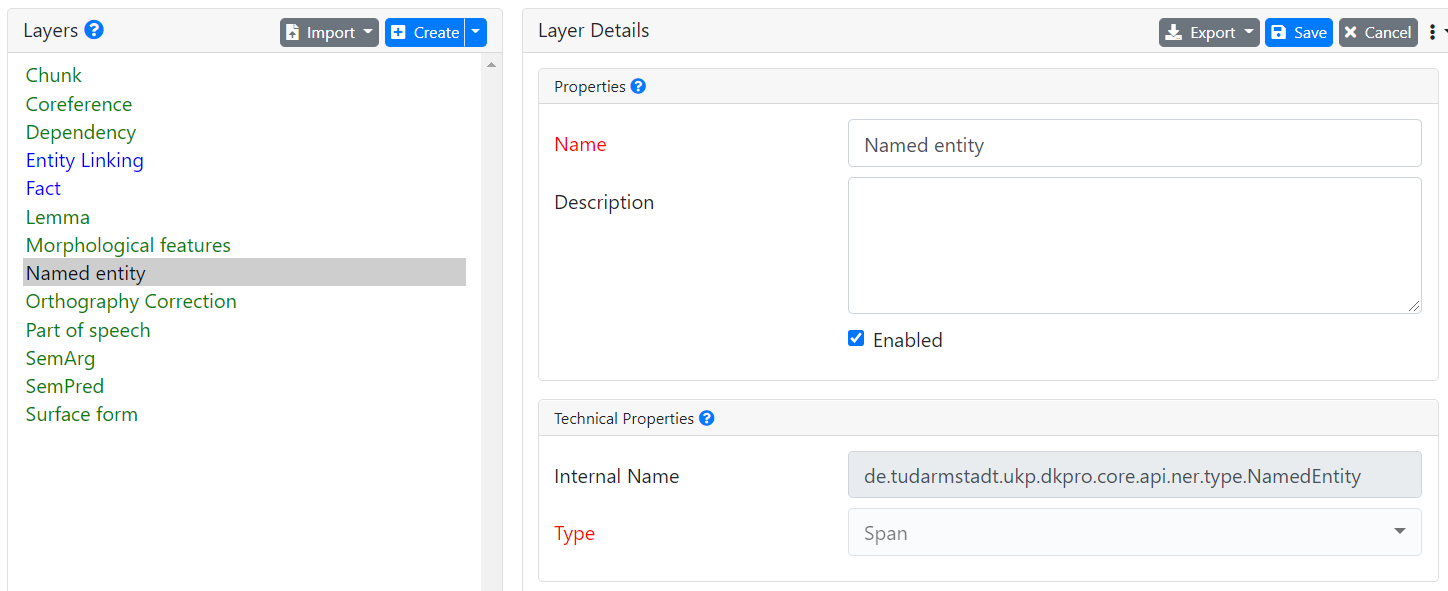

The type system will be used when creating a CAS using Python and serializing it to XMI. Type system and documents in XMI format can be accessed when exporting the project from INCEpTION as UIMA CAS XMI.

Annotated documents in this format will contain the text and for each annotation its type, the beginning and end character position of the annotation in the text and its feature values. 

The following image shows a Named Entity annotation as seen in INCEpTION and its corresponding entry in an UIMA CAS XMI file.

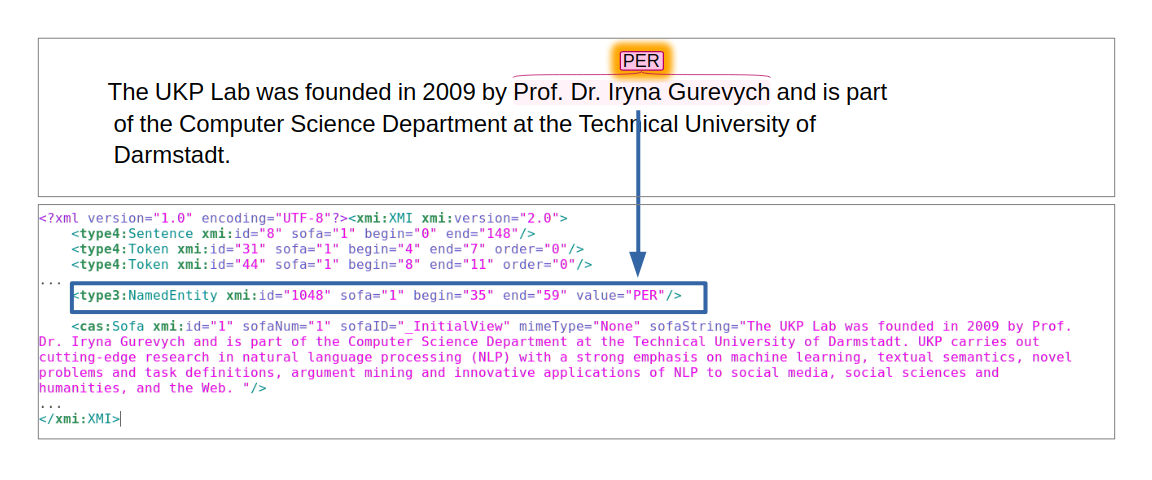

**Tokens and Sentences**

In this formalism, everything is an annotation described as a span over the document text, even tokens and sentences.

If INCEpTION does not find tokens or sentences in an imported document, then they are automatically created using the Java BreakIterator.

## Creating and importing documents with predefined sentence borders

This example describes how to import a document with already defined sentence boundaries into INCEpTION. This is e.g. interesting when importing and annotating tweets or other texts for sentence-based annotations like sentiment.

In this example, we will split a text into sentences for each line, create Sentence annotations for them corresponding to the INCEpTION typesystem and import them into INCEpTION.



### Export Type System

We need to export the INCEpTION type system so that we can load it from Python.

* In INCEpTION, go to the **Layers** tab on the project **Settings** page.
* Press the **Export** button in the **Layer Details** section, select **UIMA** and click **Download** to save the type system

### Install dependencies

In [ ]:
!pip install dkpro-cassis > /dev/null

### Create the XMI document with cassis in Python

We will use the type system below for the sake of this tutorial, it is a condensed version of the one you would have downloaded from INCEpTION.

In [ ]:
%%writefile typesystem.xml
<typeSystemDescription xmlns="http://uima.apache.org/resourceSpecifier">
    <types>
        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence</name>
            <description />
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features />
        </typeDescription>
    </types>
</typeSystemDescription>

Overwriting typesystem.xml


The following Python codesnippet then loads the type system, creates one sentence per line and saves the document as XMI.

In [ ]:
from cassis import *

# We will use this text (Source: https://en.wikipedia.org/wiki/Sentiment_analysis)
text = """Coronet has the best lines of all day cruisers.
Bertram has a deep V hull and runs easily through seas.
Pastel-colored 1980s day cruisers from Florida are ugly.
I dislike old cabin cruisers.
"""

# Load our type system
with open("typesystem.xml", "rb") as f:
  ts = load_typesystem(f)

# Create the CAS object that holds our annotations
cas = Cas(typesystem=ts)
cas.sofa_string = text

# Get annotation classes from the type system
Sentence = ts.get_type("de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence")

# Go over the lines in the text and compute (begin, end) indices for all sentences
offset = 0
for line in text.split("\n"):
  begin = offset 
  end = offset + len(line)
  sent = Sentence(begin=begin, end=end)
  cas.add_annotation(sent)
  assert line == sent.get_covered_text(), f"'{line}' != '{sent.get_covered_text()}'"

  # `end` pointed to the new line character, we move it to the first char of the next line
  offset = end + 1 
  
cas.to_xmi("sentiment.xmi")

### Import the document into INCEpTION

Go to the **Documents** tab on the project **Settings** page. Then, import the file `sentiment.xmi` as using the format **UIMA CAS XMI (XML 1.0)**. Create a layer that is locking to sentences. Then, open the document in the annotation editor and select this layer. Double clicking now will now create annotations limited by your sentence boundaries!

## Create documents with predefined sentences, tokens and existing NER annotations

This example describes how to import a document with already existing sentence, token and named entity annotations into INCEpTION.

We will create sentences and tokens using spacy and convert them to INCEpTION layer types. 
We will also create named entities using spacy but will convert them to a newly created custom layer type.
Instead, you could also use the existing Named Entity layer for this.




### Configure Annotation Scheme

We will first define the new named entity custom layer.
In INCEpTION, go to the **Layers** tab on the project **Settings** page.

* Press the **Create** button in the **Layers** list to create a new layer
* In the **Layer Details** panel
  * Set the **Name** to `MyLayer`
  * Set the **Type** to `Span`
  * Set the **Granularity** to `Token-level`
  * Press the **Save** button
* Press the **Create** button in the **Features** list to create a new feature
* In the **Feature Details** panel
  * Set the **Name** to `value`
  * Set the **Type** to `Primitive: String`
  * Press the **Save** button
* Press the **Export** button in the **Layer Details** section, select **UIMA** and click **Download** to save the type system

### Install dependencies

In [ ]:
!pip install spacy > /dev/null
!python -m spacy download en_core_web_sm  > /dev/null
!pip install dkpro-cassis > /dev/null

### Create the XMI document with cassis in Python

We will use the type system below for the sake of this tutorial, it is a condensed version of the one you would have downloaded from INCEpTION.

In [ ]:
%%writefile typesystem.xml
<typeSystemDescription xmlns="http://uima.apache.org/resourceSpecifier">
    <types>
        <typeDescription>
            <name>webanno.custom.MyLayer</name>
            <description/>
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features>
                <featureDescription>
                    <name>value</name>
                    <description/>
                    <rangeTypeName>uima.cas.String</rangeTypeName>
                </featureDescription>
            </features>
        </typeDescription>

        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence</name>
            <description />
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features />
        </typeDescription>

        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token</name>
            <description />
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features />
        </typeDescription>

    </types>
</typeSystemDescription>

Overwriting typesystem.xml


We use the following text and use spacy to tokenize, sentencize and detect named entities in it.



In [ ]:
import spacy
from spacy import displacy

text = """The UKP Lab was founded in 2009 by Prof. Dr. Iryna Gurevych and is part of the Computer Science Department at the Technical University of Darmstadt. UKP carries out cutting-edge research in natural language processing (NLP) with a strong emphasis on machine learning, textual semantics, novel problems and task definitions, argument mining and innovative applications of NLP to social media, social sciences and humanities, and the Web. """

# Process the document
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

displacy.render(doc, style="ent", jupyter=True)

Then, we use `cassis` to convert spacy tokens, sentences and annotations into a CAS that then can be imported into INCEpTION.

In [ ]:
from cassis import *

# Create the CAS
SENTENCE_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence"
TOKEN_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token"
NER_TYPE = "webanno.custom.MyLayer" # This is the Internal Name in the layer settings 

# Load our type system
with open("typesystem.xml", "rb") as f:
  ts = load_typesystem(f)

cas = Cas(typesystem=ts)
cas.sofa_string = text

Sentence = ts.get_type(SENTENCE_TYPE)
Token = ts.get_type(TOKEN_TYPE)
NamedEntity = ts.get_type(NER_TYPE)

for sentence in doc.sents:
  cas_sentence = Sentence(begin=sentence.start_char, end=sentence.end_char)
  cas.add_annotation(cas_sentence)
  assert sentence.text == cas_sentence.get_covered_text()

for token in doc:
  cas_token = Token(begin=token.idx, end=token.idx + len(token))
  cas.add_annotation(cas_token)
  assert token.text == cas_token.get_covered_text()

for named_entity in doc.ents:
    cas_named_entity = NamedEntity(begin=named_entity.start_char, end=named_entity.end_char, value = named_entity.label_)
    cas.add_annotation(cas_named_entity)
    assert named_entity.text == cas_named_entity.get_covered_text()

cas.to_xmi("named_entities.xmi")

### Import the document into INCEpTION

Go to the **Documents** tab on the project **Settings** page. Then, import the file `named_entities.xmi` as using the format **UIMA CAS XMI (XML 1.0)**. Open the document in the annotation editor, you should see the document with your tokens, sentences and annotations!

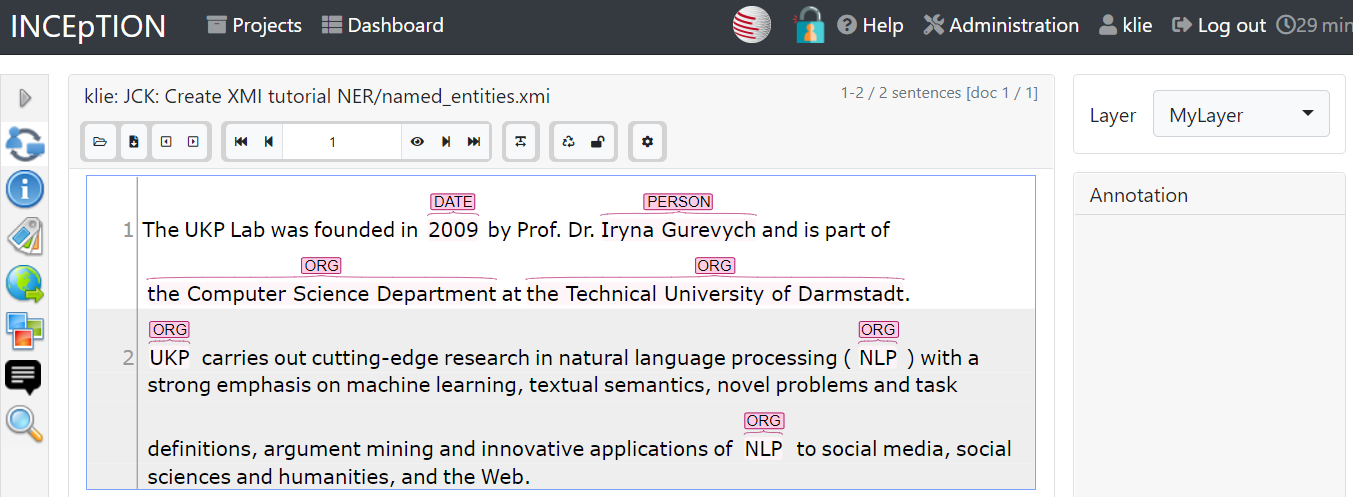